# Model validation with observation data: Gauge and altimetry



In [48]:
# Load in model discharge vals, 

# Load in river gauge data

# load altimetry, surface water extent, grace? 

import matplotlib.pyplot as plt
import geopandas as gpd
import mikeio
import shapely

def plot_settings(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # remove plot border
    for spine in ax.spines.values():
        spine.set_visible(False)

def nse_rmse_statistics(Q_mod, Q_obs):
    """
    Compute Nash-Sutcliffe Efficiency (NSE) and Root Mean Square Error (RMSE)
    for modeled and observed discharge data.
    """
    # remove NaN values - dropping the same rows from both series
    valid_mask = Q_mod.notna() & Q_obs.notna()
    Q_mod = Q_mod[valid_mask]
    Q_obs = Q_obs[valid_mask]
    print()
    nse = 1 - ((Q_obs - Q_mod) ** 2).sum() / ((Q_obs - Q_obs.mean()) ** 2).sum()
    rmse = ((Q_obs - Q_mod) ** 2).mean() ** 0.5
    return nse, rmse

In [ ]:
# ---------------------- Station Information ----------------------
chainage_dict = {"Q250018" : -3764,
        "Q250019" : -30794,
        "Q250020" : -3681,
        "Q250021" : 3900,
        "Q250078" : 26434,
        "Q250082" : 54135,
        "Q250090" : -2400,
        "Q250092" : -10576,
        "Q250097" : 61000

}

branch_dict = {"Q250018" : 'SKJERN_AA_DK5',
        "Q250019" : 'SDR_OMME_AA_DK5',
        "Q250020" : 'HOLTUM_AA_DK5',
        "Q250021" : 'BRANDE_AA_DK5',
        "Q250078" : 'SDR_OMME_AA_DK5',
        "Q250082" : 'SKJERN_AA_DK5',
        "Q250090" : 'SDR_OMME_AA_DK5',
        "Q250092" : 'GUNDESBOEL_AA_DK5',
        "Q250097" : 'SKJERN_AA_DK5'

}

Text(0.5, 1.0, 'River Discharge Station Locations')

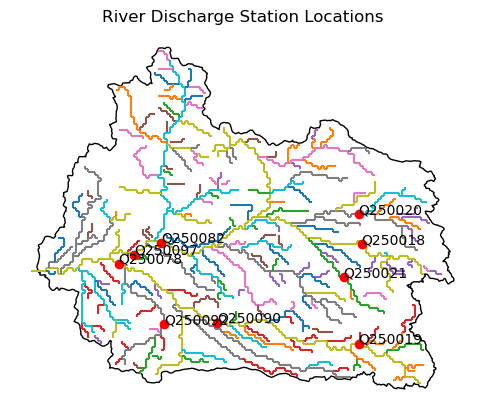

In [ ]:
# ---------------------- Plot Domain, River Connectivity, Discharge stations ----------------------

fig, ax = plt.subplots(figsize=(6, 6))

# Domain data
domain_shp = gpd.read_file( r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)

# River connectivity shapefile (simulation output)
riv_shp = gpd.read_file(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_RiverLinks.shp")
riv_shp.plot(column='Branch',ax=ax)
plot_settings(ax)


# Plot locations of river discharge stations
for stationID in branch_dict.keys():
    branch = branch_dict[stationID]
    chainage = chainage_dict[stationID]
    river = riv_shp.loc[riv_shp['Branch'] == branch]

    # get closest chainage
    closest_chain = river.iloc[(river['Chainage']-chainage).abs().argsort()[:1]]

    # get centroid of closest_chain
    centroid = shapely.centroid(closest_chain.geometry)
    centroid.plot(ax=ax,color='red',zorder=2)
    xloc = float(centroid.x.iloc[0])
    yloc = float(centroid.y.iloc[0])

    # plot stationID next to point
    plt.text(x=xloc,y=yloc,s=stationID)

plt.title('River Discharge Station Locations')
    

In [ ]:
# ---------------------- Load modeled and observed river discharge and water table depth (WTD) ----------------------


# Load Q observations
Q_obs = mikeio.read(r"..\MapsDK\Qdata\Q_filtered.dfs0")
Q_obs = Q_obs.to_dataframe()


# Load well obs (WTD)


# Load modeled Q
Q_mod = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_M11.dfs0")
Q_mod = Q_mod.to_dataframe()

# Load modeled WTD
Wtd_SZ_mod = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_SZ.dfs0")
Wtd_SZ_mod = Wtd_SZ_mod.to_dataframe()


In [ ]:
# ---------------------- Validation statistics for river discharge ----------------------

nse_rmse_results = {}
for stationID in branch_dict.keys():

    # combine data by date
    mod_daily = Q_mod[stationID].resample('D').mean()
    obs_daily = Q_obs[stationID].resample('D').mean()
    combined = mod_daily.to_frame(name='Modeled Q').join(obs_daily.to_frame(name='Observed Q'))

    # drop rows with NaN values
    combined = combined.dropna()
    
    nse, rmse = nse_rmse_statistics(combined['Modeled Q'], combined['Observed Q'])
    nse_rmse_results[stationID] = {'NSE': nse, 'RMSE': rmse}

for stationID, stats in nse_rmse_results.items():
    print(f"Station {stationID}: NSE = {stats['NSE']:.3f}, RMSE = {stats['RMSE']:.3f}")











Station Q250018: NSE = 0.096, RMSE = 0.477
Station Q250019: NSE = 0.574, RMSE = 0.550
Station Q250020: NSE = 0.586, RMSE = 0.282
Station Q250021: NSE = 0.612, RMSE = 0.171
Station Q250078: NSE = 0.800, RMSE = 2.176
Station Q250082: NSE = 0.786, RMSE = 3.262
Station Q250090: NSE = 0.655, RMSE = 1.106
Station Q250092: NSE = 0.657, RMSE = 0.487
Station Q250097: NSE = 0.672, RMSE = 6.244


Text(0.02, 0.5, 'Discharge (m³/s)')

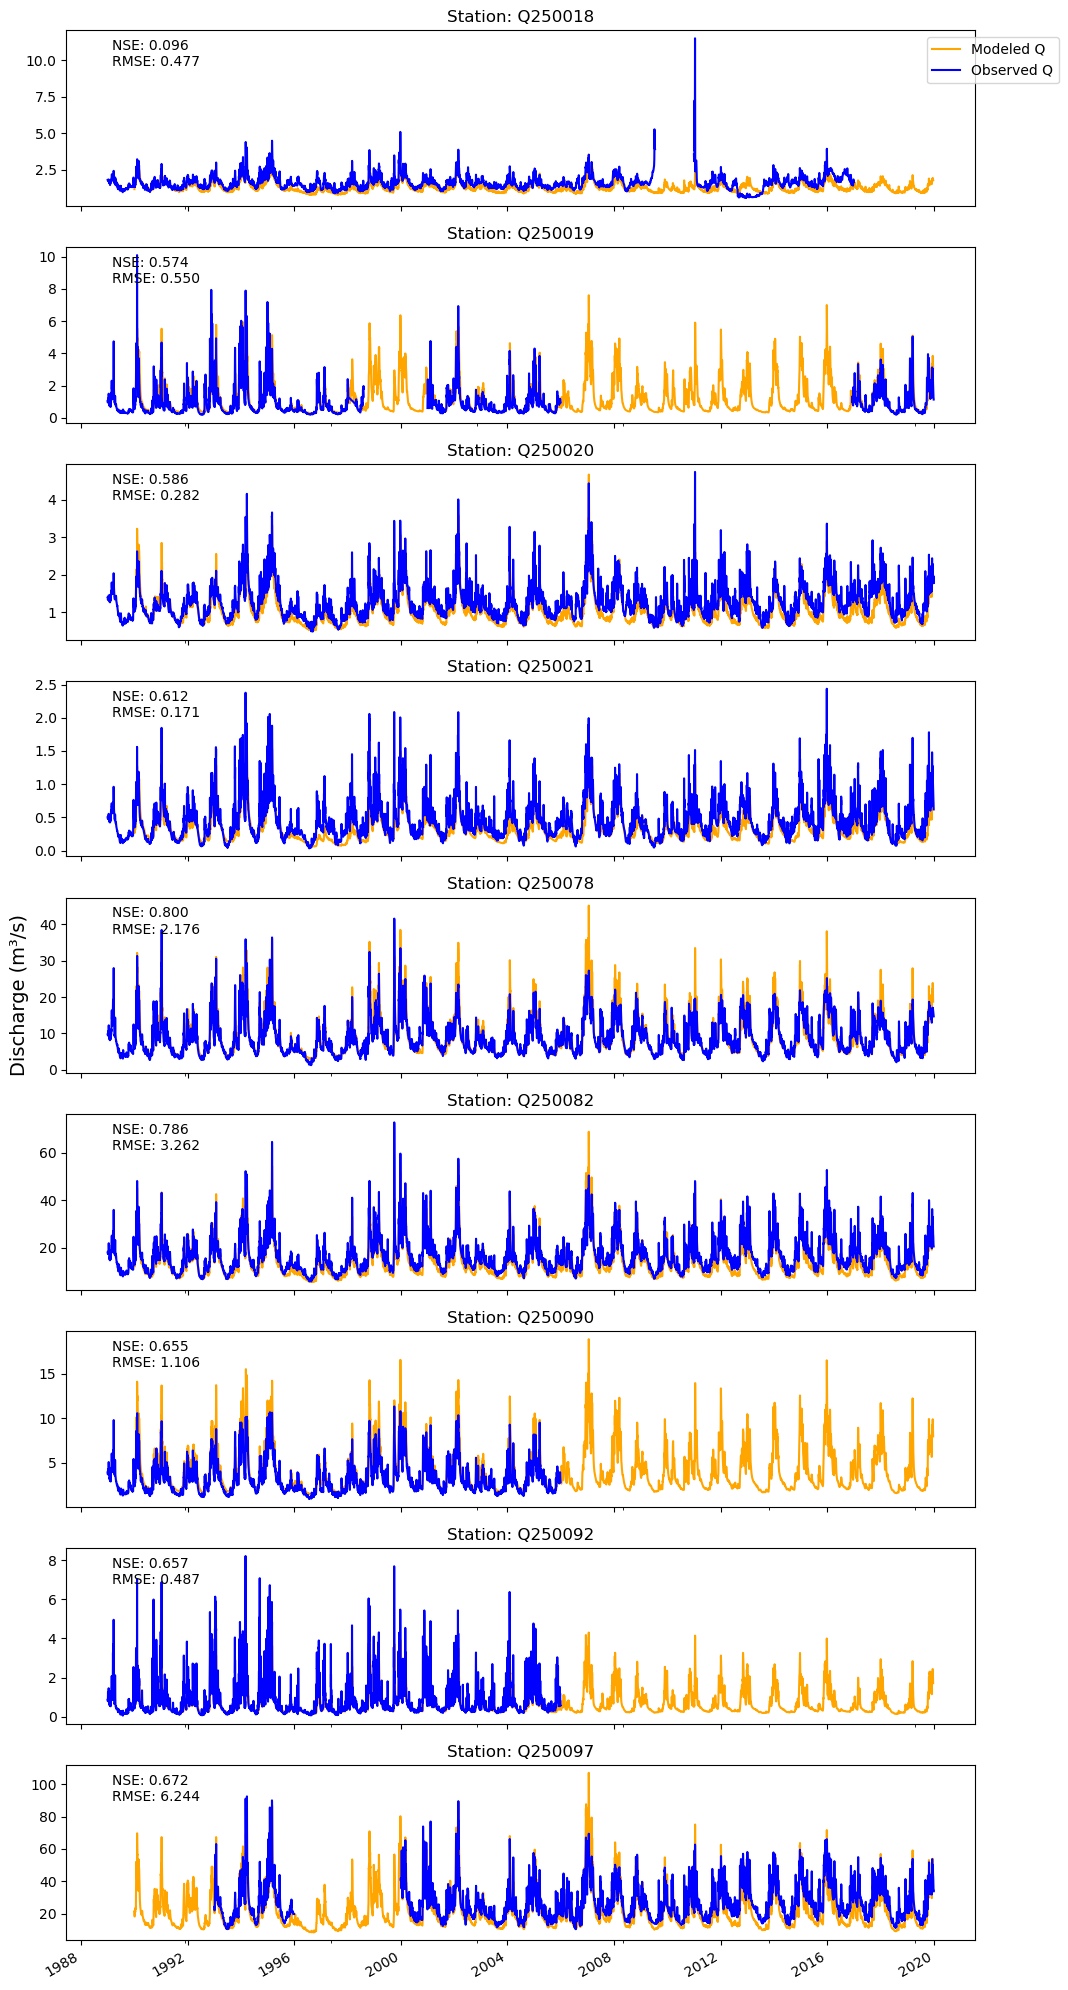

In [ ]:
# ---------------------- Plot modeled vs observed Q for each station ----------------------

fig, ax = plt.subplots(nrows=len(branch_dict),ncols=1,sharex=True,figsize=(10,20))
i=0
for stationID in branch_dict.keys():
    
    Q_mod[stationID].plot(ax=ax[i], label=f'Modeled Q', color='orange')
    Q_obs[stationID].plot(ax=ax[i], label=f'Observed Q', color='blue')
    ax[i].set_title(f'Station: {stationID}')

    nse = nse_rmse_results[stationID]['NSE']
    rmse = nse_rmse_results[stationID]['RMSE']
    ax[i].text(0.05, 0.95, f'NSE: {nse:.3f}\nRMSE: {rmse:.3f}', transform=ax[i].transAxes, fontsize=10, verticalalignment='top')
    i += 1


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=ax[0].transAxes)
plt.tight_layout(rect=(0.025,0,1,1))

#fig.suptitle('Modeled vs Observed Discharge at River Stations', fontsize=16)
fig.supylabel('Discharge (m³/s)', fontsize=14)


In [ ]:
# ---------------------- Validation statistics for WTD ----------------------


In [ ]:
# ---------------------- Plot modeled vs observed maps of WTD for time slices ----------------------
